In [1]:
!pip install pmdarima

In [2]:
# Suppress warnings 

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
# Importing neccessary libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import itertools
import statsmodels.api as sm
import seaborn as sns
sns.set()

In [4]:
# Display all columns of the dataframe
pd.options.display.max_columns = None

# Display all rows of the dataframe
pd.options.display.max_rows = 50 # None

# Returns an output value upto 6 decimals
pd.options.display.float_format = '{:.2f}'.format

Loading the data

In [5]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

nasdaq = pd.read_csv("NASDAQ Data/NASDAQ Training Data - 1st Jan 2016 to 1st Jan 2022.csv", index_col='Date', parse_dates=['Date'], date_parser=dateparse)
nasdaq.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,4897.65,4903.09,4846.98,4903.09,4903.09,2218420000
2016-01-05,4917.84,4926.73,4872.74,4891.43,4891.43,1927380000
2016-01-06,4813.76,4866.04,4804.69,4835.76,4835.76,2168620000
2016-01-07,4736.40,4788.02,4688.17,4689.43,4689.43,2552590000
2016-01-08,4722.02,4742.57,4637.85,4643.63,4643.63,2288750000


Summarizing Data

In [6]:
nasdaq.shape

(1259, 6)

In [7]:
nasdaq.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.00,1259.00,1259.00,1259.00,1259.00,1259.00
mean,7359.16,7404.31,7309.73,7361.23,7361.23,2432290293.88
std,1903.79,1920.19,1883.79,1904.01,1904.01,958291546.79
min,4218.81,4293.22,4209.76,4266.84,4266.84,149410000.00
25%,5877.05,5904.62,5859.50,5879.94,5879.94,1857675000.00
50%,7293.65,7350.07,7235.05,7298.28,7298.28,2095180000.00
75%,8124.43,8158.09,8073.86,8118.18,8118.18,2521720000.00
max,12965.39,12973.33,12857.76,12899.42,12899.42,7693430000.00


In [8]:
# Checking for missing values

In [9]:
nasdaq.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
# There are no missing values

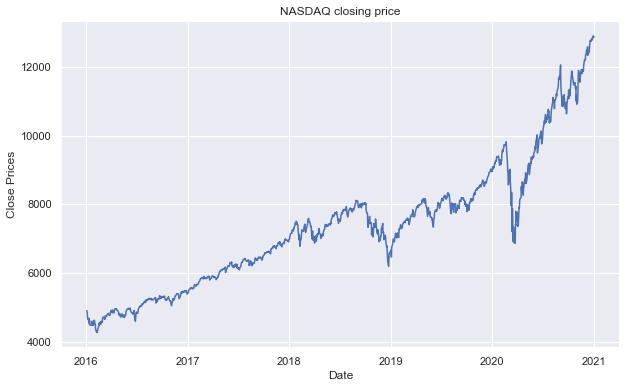

In [11]:
# Plot close price

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(nasdaq['Close'])
plt.title('NASDAQ closing price')
plt.show()

In [12]:
nasdaq_close = nasdaq['Close']

Test for staionarity

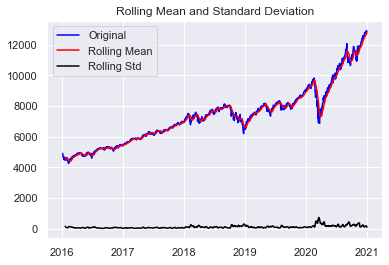

Test Statistics                  0.69
p-value                          0.99
No. of lags used                 9.00
Number of observations used   1249.00
critical value (1%)             -3.44
critical value (5%)             -2.86
critical value (10%)            -2.57
dtype: float64


<Figure size 720x432 with 0 Axes>

In [13]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot 
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    plt.figure(figsize=(10,6))
    
    adft = adfuller(timeseries,autolag='AIC')    
    
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
        
    print(output)
test_stationarity(nasdaq_close)

Our series isn't stationary

<Figure size 432x288 with 0 Axes>

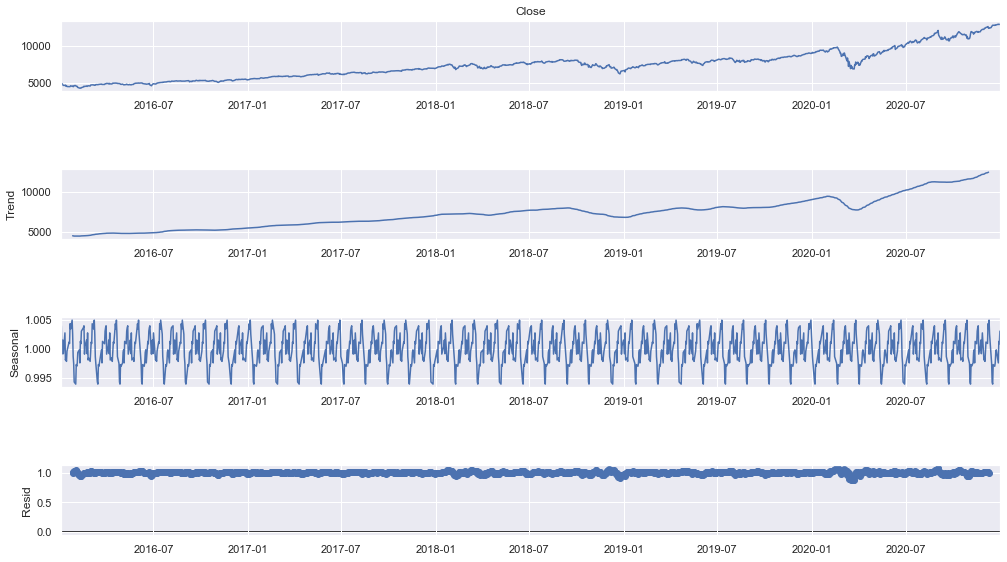

In [14]:
result = seasonal_decompose(nasdaq_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


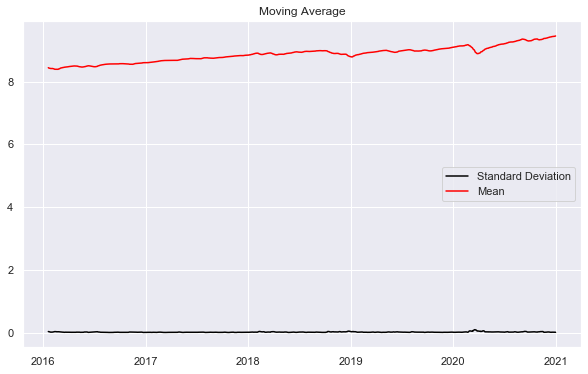

In [15]:
# If not stationary then eliminate trend
# Eliminating trend

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(nasdaq_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

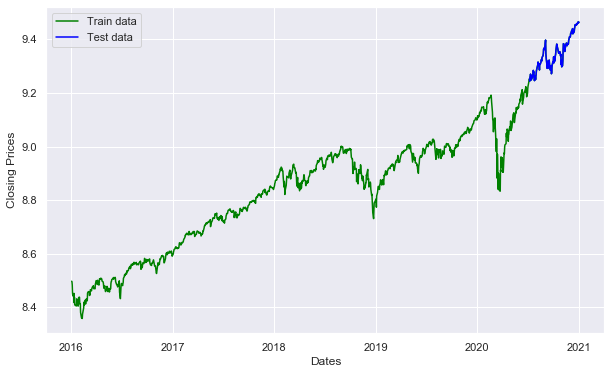

In [16]:
#Split data into train and training set

train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6520.351, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6588.204, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6575.583, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6519.395, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6592.526, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-6595.425, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-6592.842, Time=0.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6581.616, Time=0.44 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-6593.757, Time=0.11 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 2.899 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1130
Model:               SARIMAX(3, 1, 0)   Log Likelihood                3302.712
Date:                Tue, 08 Feb 2022   

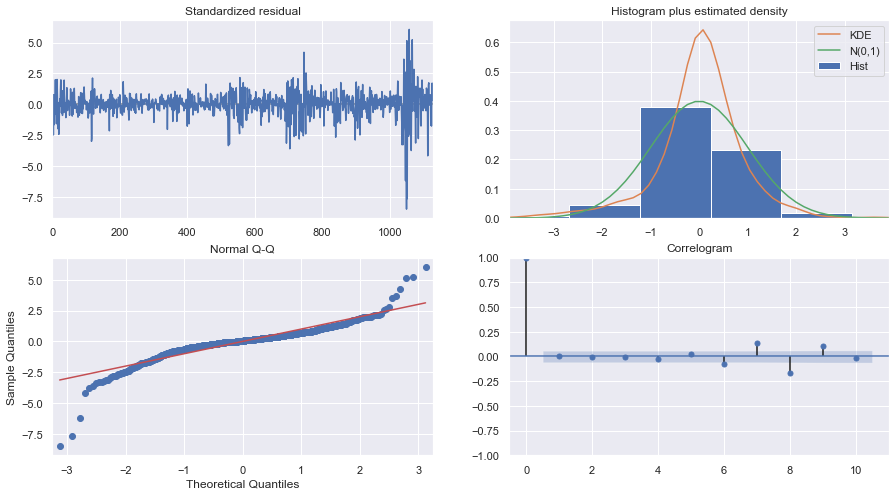

In [17]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [18]:
# Modeling
# Build Model

model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1129
Model:                 ARIMA(1, 1, 2)   Log Likelihood                3298.102
Method:                       css-mle   S.D. of innovations              0.013
Date:                Tue, 08 Feb 2022   AIC                          -6586.205
Time:                        15:54:50   BIC                          -6561.059
Sample:                             1   HQIC                         -6576.704
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.000      2.233      0.026    8.44e-05       0.001
ar.L1.D.Close    -0.9198      0.025    -36.309      0.000      -0.970      -0.870
ma.L1.D.Close     0.7437      0.033     

In [19]:
 #Forecasting
fc, se, conf = fitted.forecast(126, alpha=0.05)  # 95% conf

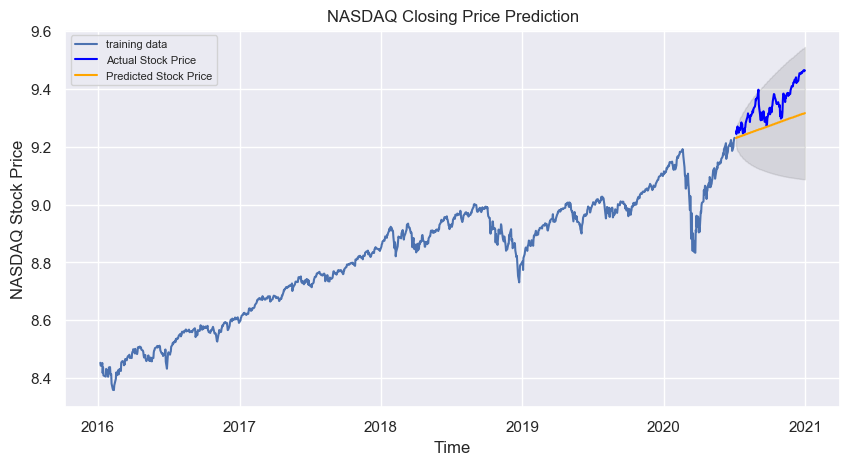

In [20]:
# Make as pandas series

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('NASDAQ Closing Price Prediction')
plt.xlabel('Time')
plt.ylabel('NASDAQ Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [21]:
# Report performance

mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.006734610940621012
MAE: 0.07153578025481895
RMSE: 0.08206467535195038
MAPE: 0.007628840772089458


In [22]:
# The error rate is 0.07%. This means the model performed with a accuracy of 99.3%